In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torchvision.transforms as tt

from matplotlib import pyplot as plt
import numpy as np

import json
import urllib
from pytorchvideo.data.encoded_video import EncodedVideo

from torchvision.transforms import Compose, Lambda
from torchvision.transforms._transforms_video import (
    CenterCropVideo,
    NormalizeVideo,
)
from pytorchvideo.transforms import (
    ApplyTransformToKey,
    ShortSideScale,
    UniformTemporalSubsample
)

/nfs/helium2/arjun/.conda/envs/llava/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Get transform
trainset = torchvision.datasets.CIFAR100(root='./data', train=True,
                                        download=True)
testset = torchvision.datasets.CIFAR100(root='./data', train=False,
                                       download=True)

# Stick all the images together to form a 1600000 X 32 X 3 array
x = np.concatenate([np.asarray(trainset[i][0]) for i in range(len(testset))])

# calculate the mean and std along the (0, 1) axes
mean = np.mean(x, axis=(0, 1))/255
std = np.std(x, axis=(0, 1))/255
# the the mean and std
mean=mean.tolist()
std=std.tolist()

print(mean)
print(std)

100%|██████████| 169001437/169001437 [00:49<00:00, 3385851.95it/s] 


Extracting ./data/cifar-100-python.tar.gz to ./data
Files already downloaded and verified
[0.5058918137254902, 0.4859552125459559, 0.4411151014859069]
[0.26766681344702586, 0.2560914330229496, 0.27595397525087484]


In [3]:
'''
Step 1: Download dataset & set up data loader
Luckly no custom dataset is needed, we can use CIFAR100 dataset from torchvision
'''

# Define the transformation using the calculated mean and std
mean = [0.5059, 0.4860, 0.4411]
std = [0.2677, 0.2561, 0.2759]
transform_train = tt.Compose([
                         tt.RandomCrop(32, padding=4,padding_mode='reflect'), 
                         tt.RandomHorizontalFlip(), 
                         tt.ToTensor(), 
                         tt.Normalize(mean,std,inplace=True)
						 ])

transform_test = tt.Compose([
                            tt.ToTensor(), 
							 tt.Normalize(mean,std)
							 ])

# define the datasets
trainset = torchvision.datasets.CIFAR100(root='./data', train=True,
                                        download=True, transform=transform_train)
testset = torchvision.datasets.CIFAR100(root='./data', train=False,
                                       download=True, transform=transform_test)


# define the datasets
train_loader = DataLoader(trainset, batch_size=4, shuffle=True)
test_loader = DataLoader(testset, batch_size=4, shuffle=False)


Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([4, 3, 32, 32]) torch.Size([4])


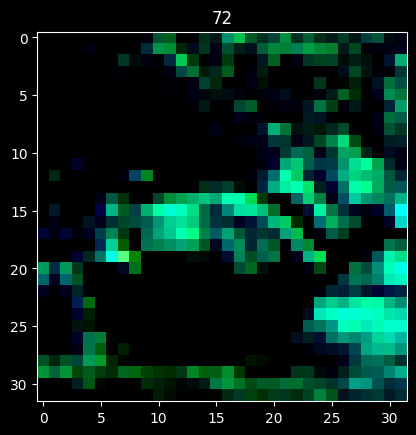

In [4]:
'''
Step 1.1: lets test the dataloader
'''

for images, labels in train_loader:
    print(images.size(), labels.size())
    plt.imshow(np.transpose(images[0].numpy(), (1, 2, 0)))
    plt.title(labels[0].item())
    plt.show()

    break


In [6]:
# Step 2: Define the model

model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', pretrained=True)


Using cache found in /home/aagrawal/.cache/torch/hub/pytorch_vision_v0.10.0
